This notebook is desined for tabular classification tasks with pandas and scikit-learn.
It is a simple example of how to use pandas and scikit-learn to build a classification model using a tabular dataset. The code includes data preprocessing, model training, and evaluation steps.
The dataset used in this example is the bank marketing dataset from the UCI Machine Learning Repository. The dataset contains information about a bank's marketing campaign and whether or not a customer subscribed to a term deposit.
The goal is to predict whether a customer will subscribe to a term deposit based on their demographic and behavioral features.


In [46]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [47]:
data=pd.read_csv('/home/tisinr/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [48]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

In [49]:
data['poutcome'].value_counts(dropna=False)

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [50]:
data.head()

,age,job,marital_status,education,credit_default,balance,housing_loan,personal_loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [51]:
data.isnull().sum()

age               0
job               0
marital_status    0
education         0
credit_default    0
balance           0
housing_loan      0
personal_loan     0
contact           0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
response          0
dtype: int64

Determine if data is imbalance

In [52]:
data['response'].value_counts()/len(data)*100

response
no     88.30152
yes    11.69848
Name: count, dtype: float64

In [53]:
data['contact'].value_counts()/len(data)*100

contact
cellular     64.774059
unknown      28.798301
telephone     6.427639
Name: count, dtype: float64

In [54]:
def na_n_fill(data):
    # Replace 'unknown' in 'contact' column with 'undefined'
    data['contact'] = data['contact'].replace('unknown', 'undefine')
    data['job'].fillna(data['job'].mode()[0], inplace=True)
    data['education'].fillna(data['education'].mode()[0], inplace=True)
    data.drop('poutcome', axis=1, inplace=True)
    return data

data = na_n_fill(data)


<positron-console-cell-54>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
<positron-console-cell-54>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-54>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behav

Exploratory Data Analysis with Pandas

<Figure size 800x1200 with 0 Axes>

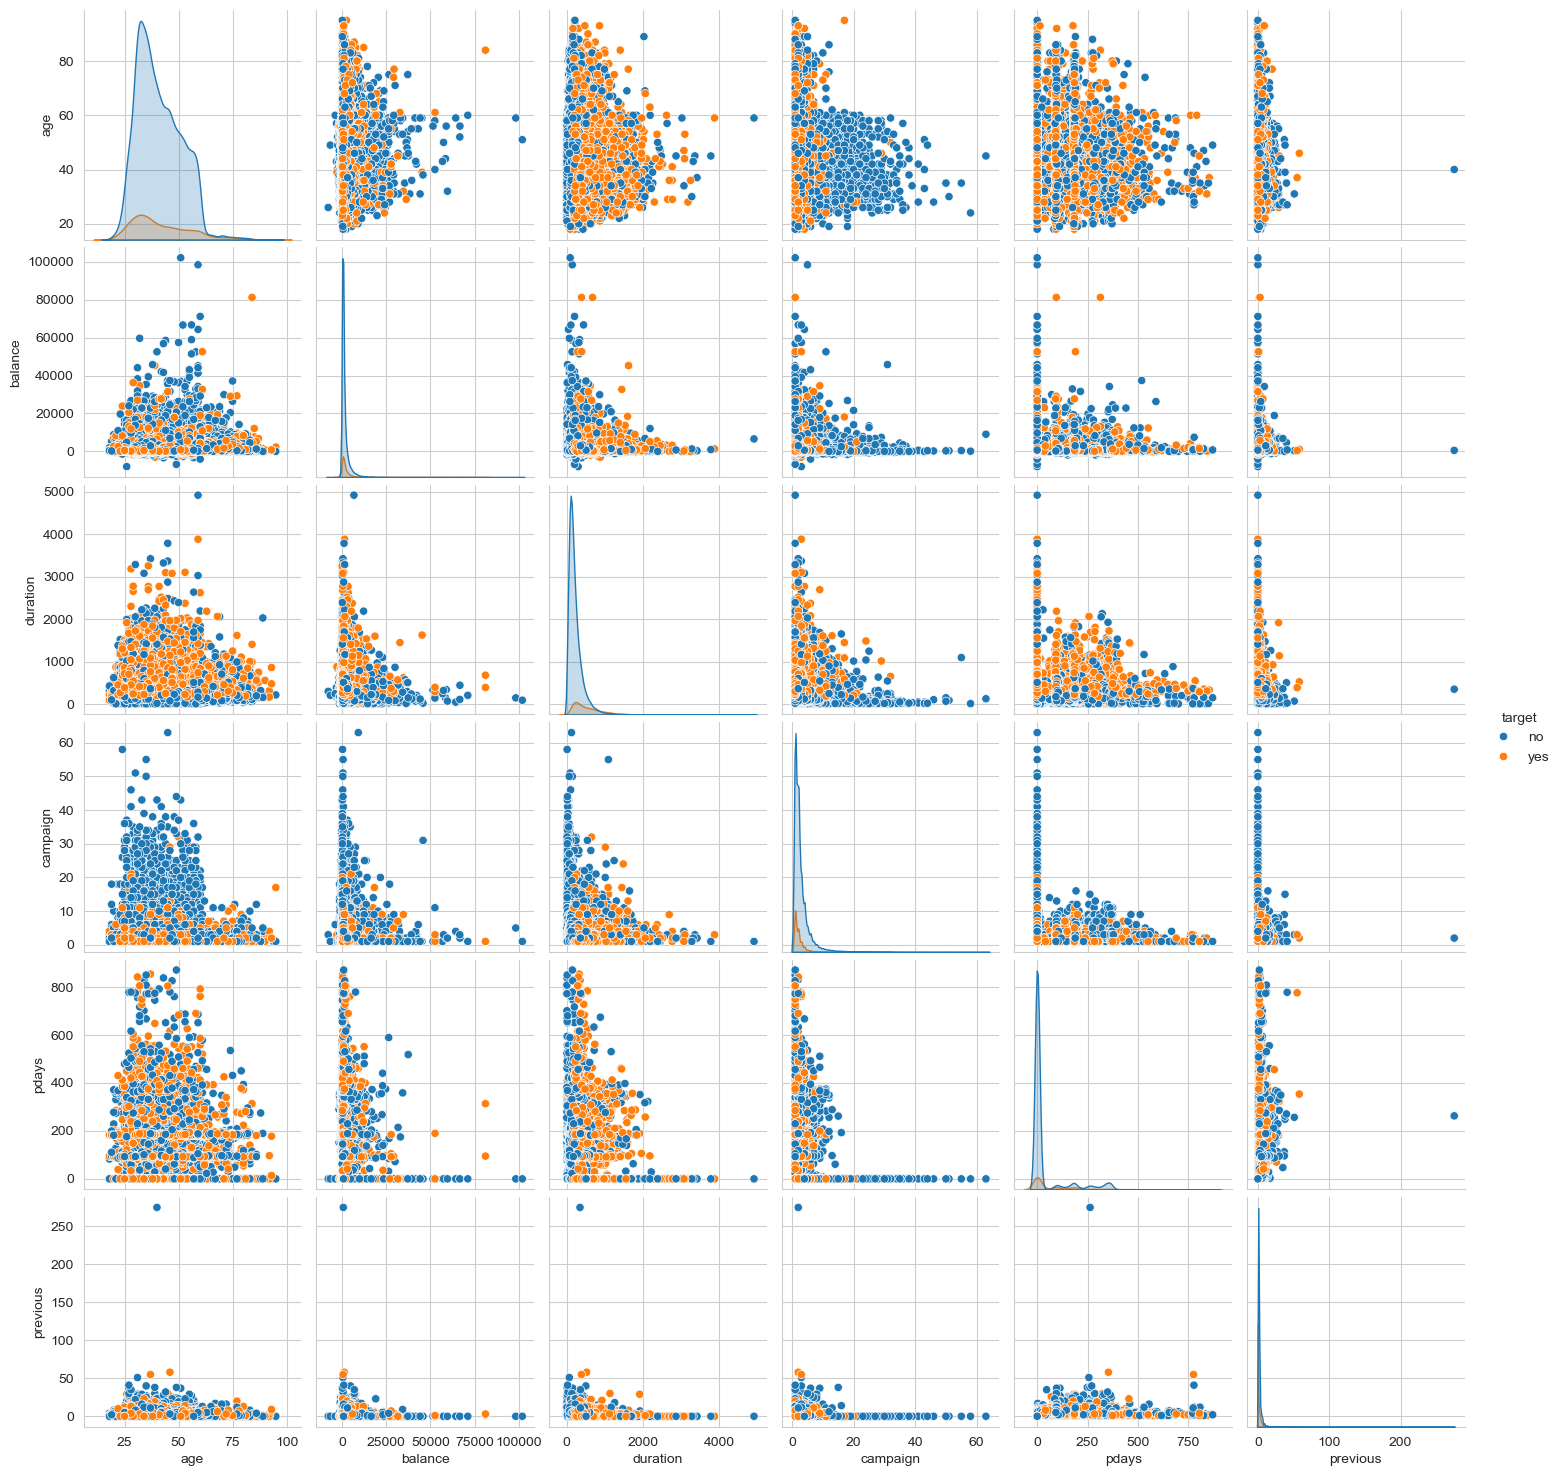

In [12]:
plt.figure(figsize=(8,12))
sns.set_style('whitegrid')
sns.pairplot(data,hue='target')
plt.show()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             45211 non-null  category
 2   marital_status  45211 non-null  category
 3   education       45211 non-null  category
 4   credit_default  45211 non-null  category
 5   balance         45211 non-null  int64   
 6   housing_loan    45211 non-null  category
 7   personal_loan   45211 non-null  category
 8   contact         45211 non-null  category
 9   day             45211 non-null  category
 10  month           45211 non-null  category
 11  duration        45211 non-null  int64   
 12  campaign        45211 non-null  int64   
 13  pdays           45211 non-null  int64   
 14  previous        45211 non-null  int64   
 15  target          45211 non-null  category
dtypes: category(10), int64(6)
memory usage: 2.5 MB


In [14]:
data.describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


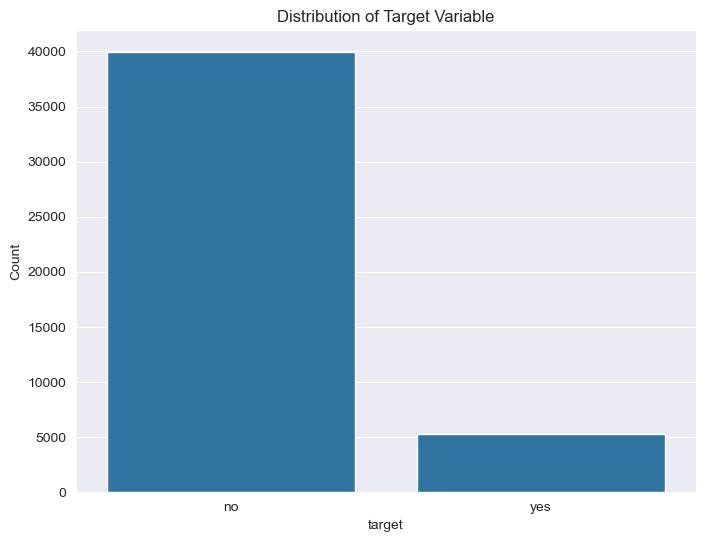

In [15]:
#Distribution plot of target variable
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()


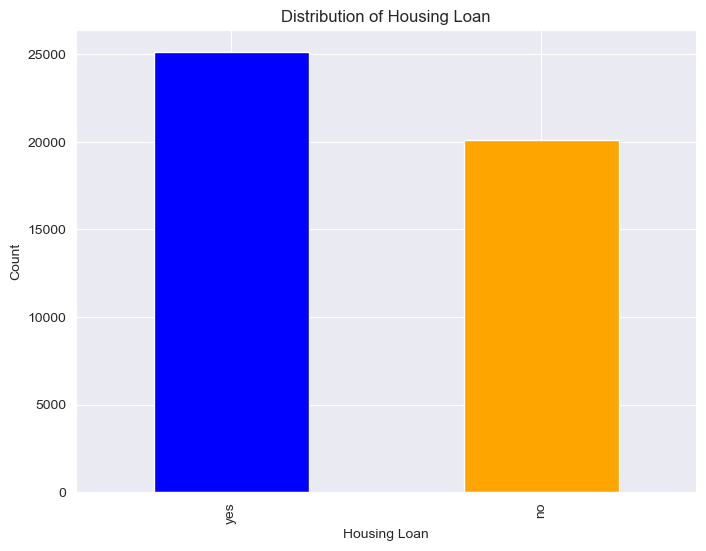

In [17]:
plt.figure(figsize=(8, 6))
data['housing_loan'].value_counts().plot(kind='bar',color=['blue', 'orange'])
plt.title('Distribution of Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.show()

<Figure size 1200x800 with 0 Axes>

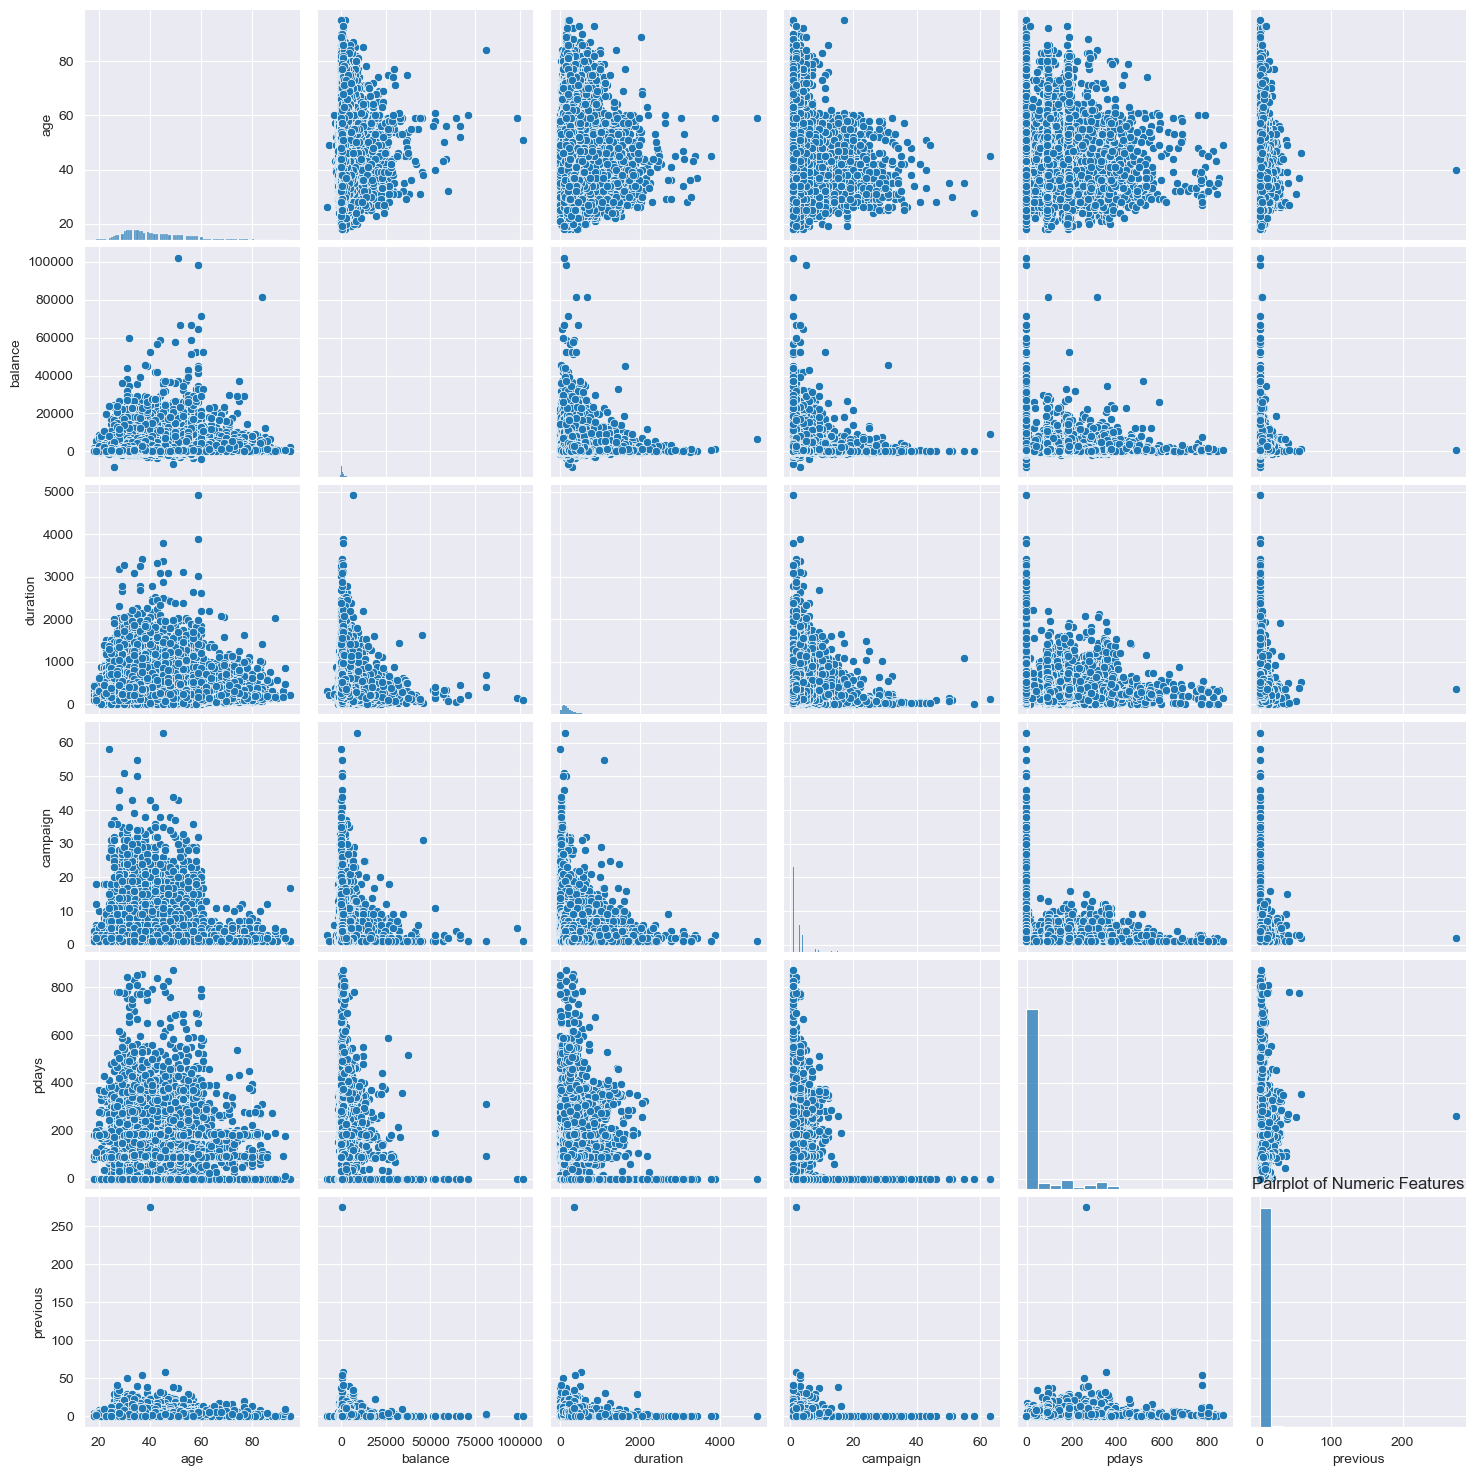

In [18]:
# Distribution plot of numeric features
plt.figure(figsize=(12, 8))
numeric_ft = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
sns.pairplot(numeric_ft)
plt.title('Pairplot of Numeric Features')
plt.show()


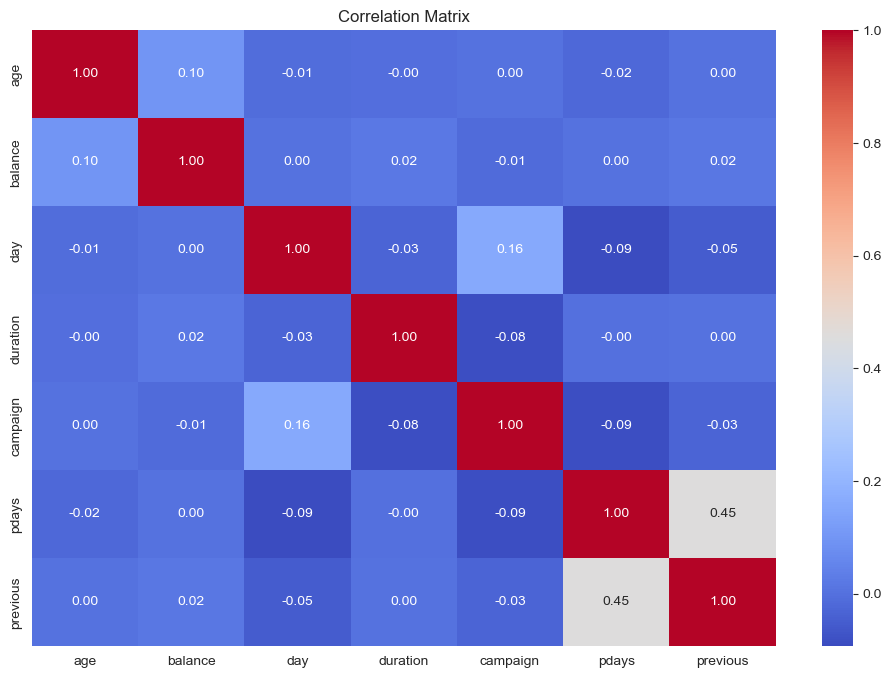

In [19]:
#Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
corr_matrix = numeric_ft.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
def plot_categorical_distribution(data, column):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=data)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()
plot_categorical_distribution(data, 'job')
plot_categorical_distribution(data, 'marital_status')
plot_categorical_distribution(data, 'education')
plot_categorical_distribution(data, 'contact')
plot_categorical_distribution(data, 'month')
plot_categorical_distribution(data, 'day')
plot_categorical_distribution(data, 'credit_default')
plot_categorical_distribution(data, 'housing_loan')
plot_categorical_distribution(data, 'personal_loan')
plot_categorical_distribution(data, 'target')
# Function to plot categorical features against the target variable
def plot_categorical_vs_target(data, column):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, hue='target', data=data)
    plt.title(f'{column} vs Target Variable')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Target', loc='upper right')
    plt.show()
plot_categorical_vs_target(data, 'job')
plot_categorical_vs_target(data, 'marital_status')
plot_categorical_vs_target(data, 'education') 
plot_categorical_vs_target(data, 'contact')
plot_categorical_vs_target(data, 'month')
plot_categorical_vs_target(data, 'day')
plot_categorical_vs_target(data, 'credit_default')
plot_categorical_vs_target(data, 'housing_loan')
plot_categorical_vs_target(data, 'personal_loan')
# Function to plot numeric features against the target variable
def plot_numeric_vs_target(data, column):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='target', y=column, data=data)
    plt.title(f'{column} vs Target Variable')
    plt.xlabel('Target')
    plt.ylabel(column)
    plt.show()
plot_numeric_vs_target(data, 'age')
plot_numeric_vs_target(data, 'balance')
plot_numeric_vs_target(data, 'day')
plot_numeric_vs_target(data, 'duration')
plot_numeric_vs_target(data, 'campaign')
plot_numeric_vs_target(data, 'pdays')
plot_numeric_vs_target(data, 'previous')
# Function to plot the distribution of numeric features
def plot_numeric_distribution(data, column):
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()
plot_numeric_distribution(data, 'age')
plot_numeric_distribution(data, 'balance')
plot_numeric_distribution(data, 'day')
plot_numeric_distribution(data, 'duration')
plot_numeric_distribution(data, 'campaign')
plot_numeric_distribution(data, 'pdays')
plot_numeric_distribution(data, 'previous')


Assign features and labels

In [20]:
X=data.drop(columns=['target'])
y=data['target']
print(X.shape)
print(y.shape)

(45211, 15)
(45211,)


Apply Preprocessing to Data

In [21]:
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan','contact','credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])

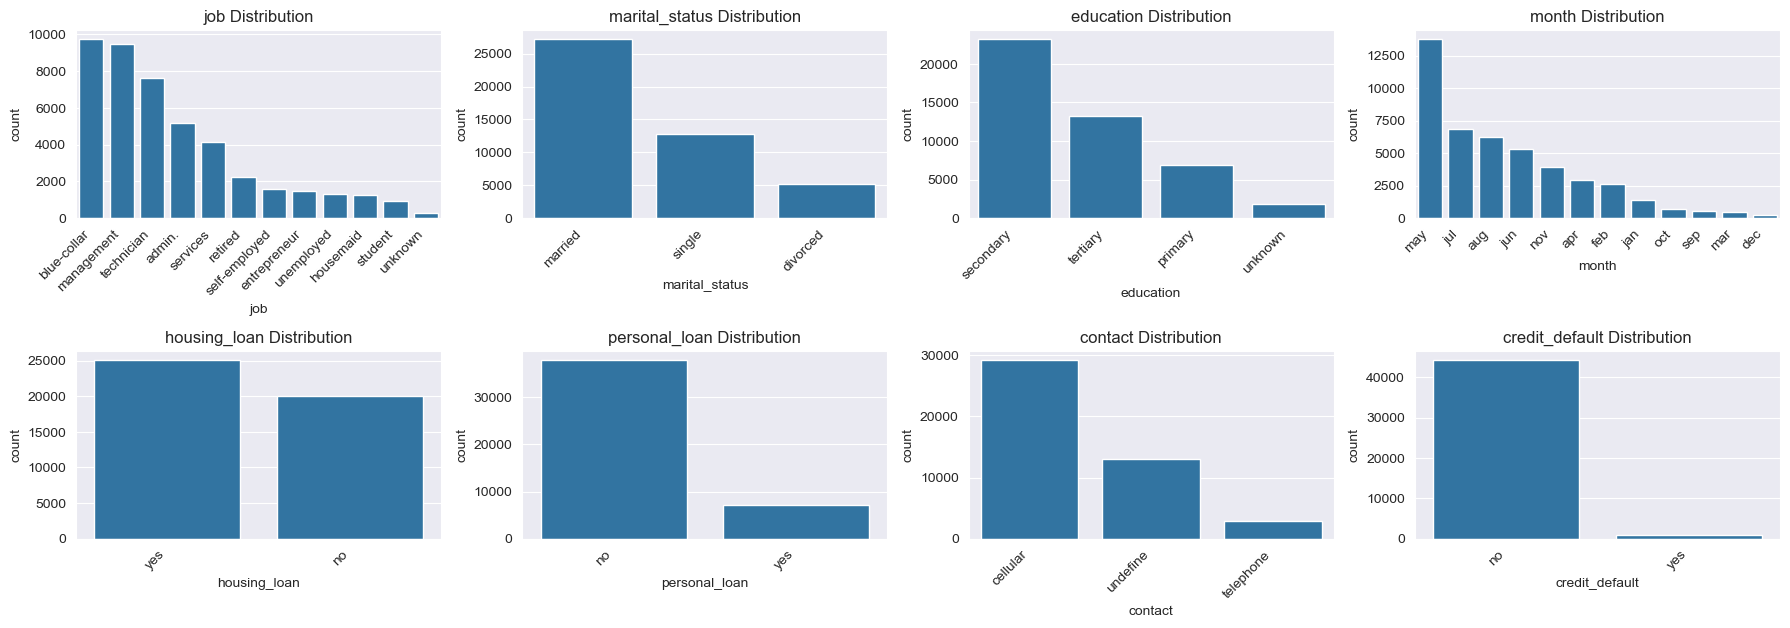

In [22]:
# Create subplots for the categorical variables
plt.figure(figsize=(18, 12))  

for i, variable in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i)  # Create a 4x4 grid of subplots
    sns.countplot(data=data, x=variable, order=data[variable].value_counts().index)
    plt.title(f'{variable} Distribution')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Ensuring subplots do not overlap
plt.show()  # Display the plot

In [23]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

In [25]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [26]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

In [27]:
print(X_train.shape)
print(X_test.shape)


(36168, 47)
(9043, 47)


In [28]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Logistic Regression with Scikit-learn training steps

In [29]:
#Instantiate and train
logreg=LogisticRegression(class_weight= 'balanced')
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [30]:
logreg.score(X_train,y_train)

0.8370228888123493

In [31]:
logreg.score(X_test,y_test)

0.8256109698109034

Logistic Regression
Accuracy:  0.8256109698109034
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.80      0.52      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.81      0.71      9043
weighted avg       0.90      0.83      0.85      9043

Confusion Matrix: 
 [[6624 1361]
 [ 216  842]]
ROC_AUC_Score:  0.890207063575016


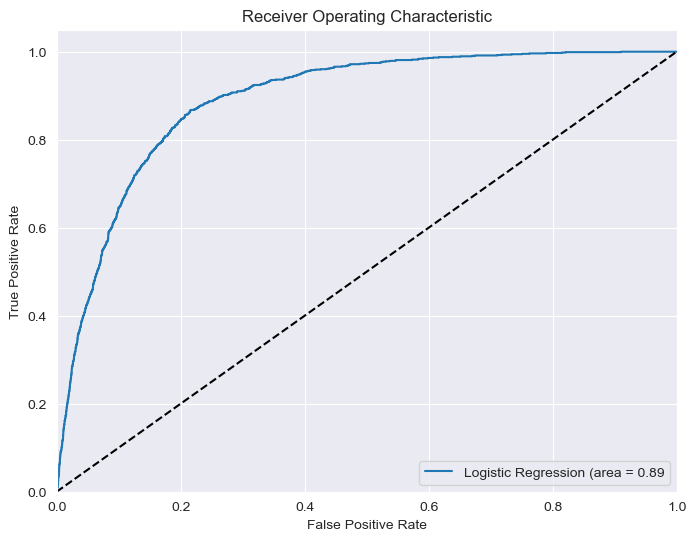

In [33]:
# Predict, Evaluate and plot
y_pred=logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
print("Logistic Regression")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC_AUC_Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Logistic Regression (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()     

Decision Tree with Scikit-learn training steps

Decision Tree Classifier
Accuracy:  0.8690699988941722
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      7985
           1       0.45      0.53      0.49      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.72      0.71      9043
weighted avg       0.88      0.87      0.87      9043

Confusion Matrix: 
 [[7301  684]
 [ 500  558]]
ROC AUC Score:  0.7208747971444568


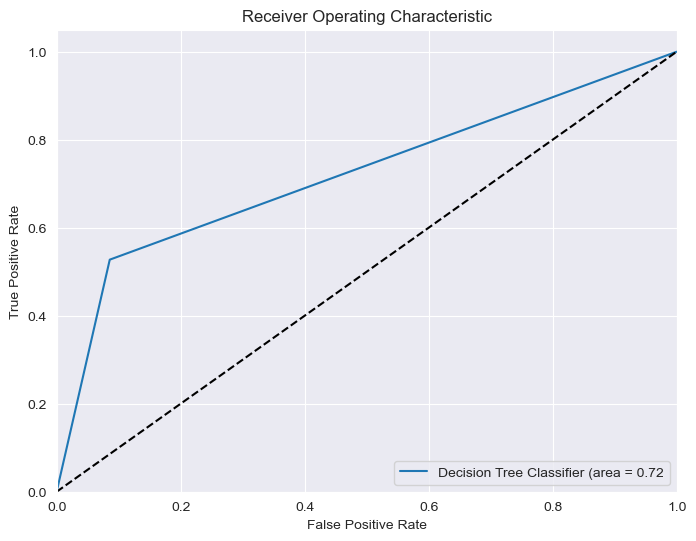

In [34]:
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)
y_pred_proba=dtree.predict_proba(X_test)[:,1]
print("Decision Tree Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Decision Tree Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Random Forest with Scikit-learn training steps

Random Forest Classifier
Accuracy:  0.8936193741015149
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.55      0.55      0.55      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.74      0.74      9043
weighted avg       0.89      0.89      0.89      9043

Confusion Matrix: 
 [[7504  481]
 [ 481  577]]
ROC AUC Score:  0.9191876190352184


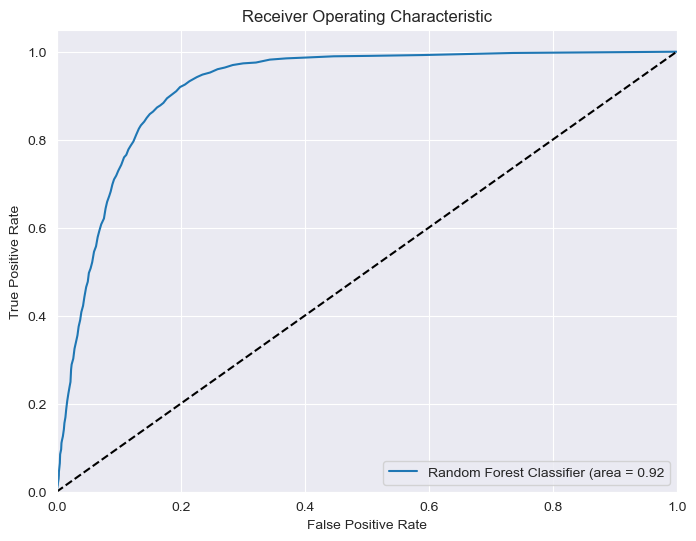

In [35]:
#Random Forest Classifier
rforest=RandomForestClassifier(class_weight= 'balanced',n_estimators=100)
rforest.fit(X_train,y_train)
y_pred=rforest.predict(X_test)
y_pred_proba=rforest.predict_proba(X_test)[:,1]
print("Random Forest Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Random Forest Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Gradient Boosting with Scikit-learn training steps

Gradient Boosting Classifier
Accuracy:  0.8709499060046445
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      7985
           1       0.47      0.75      0.58      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.82      0.75      9043
weighted avg       0.91      0.87      0.88      9043

Confusion Matrix: 
 [[7086  899]
 [ 268  790]]
ROC AUC Score:  0.9080588248523638


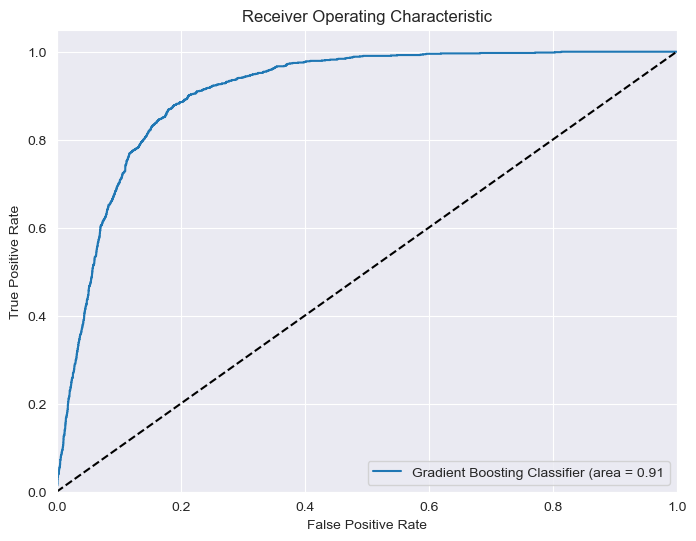

In [36]:
#Gradient Boosting Classifier
gbm=GradientBoostingClassifier()
gbm.fit(X_train,y_train)
y_pred=gbm.predict(X_test)
y_pred_proba=gbm.predict_proba(X_test)[:,1]
print("Gradient Boosting Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gradient Boosting Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

SVC with Scikit-learn training steps

Support Vector Classifier
Accuracy:  0.856352980205684
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      7985
           1       0.44      0.83      0.57      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.84      0.74      9043
weighted avg       0.91      0.86      0.87      9043

Confusion Matrix: 
 [[6870 1115]
 [ 184  874]]
ROC AUC Score:  0.9182813237959171


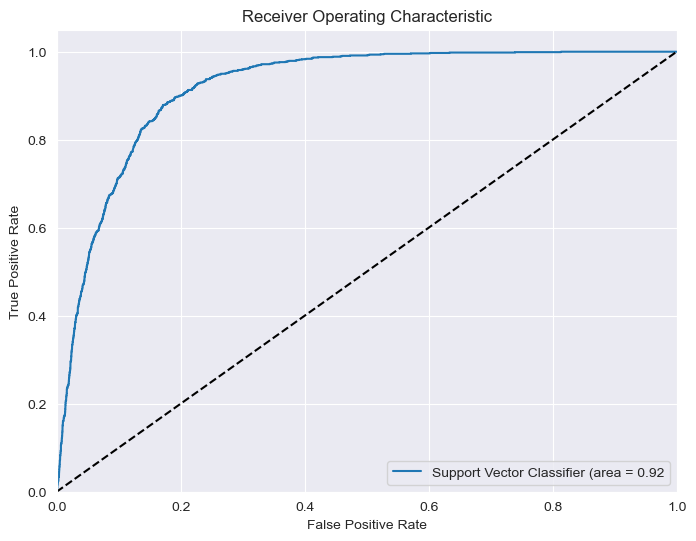

In [37]:
#Support Vector Classifier
svc=SVC(class_weight= 'balanced',probability=True)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
y_pred_proba=svc.predict_proba(X_test)[:,1]
print("Support Vector Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Support Vector Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

GaussianNB with Scikit-learn training steps

Gaussian Naive Bayes
Accuracy:  0.7391352427291827
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84      7985
           1       0.26      0.66      0.37      1058

    accuracy                           0.74      9043
   macro avg       0.60      0.70      0.60      9043
weighted avg       0.86      0.74      0.78      9043

Confusion Matrix: 
 [[5991 1994]
 [ 365  693]]
ROC AUC Score:  0.7535330303866062


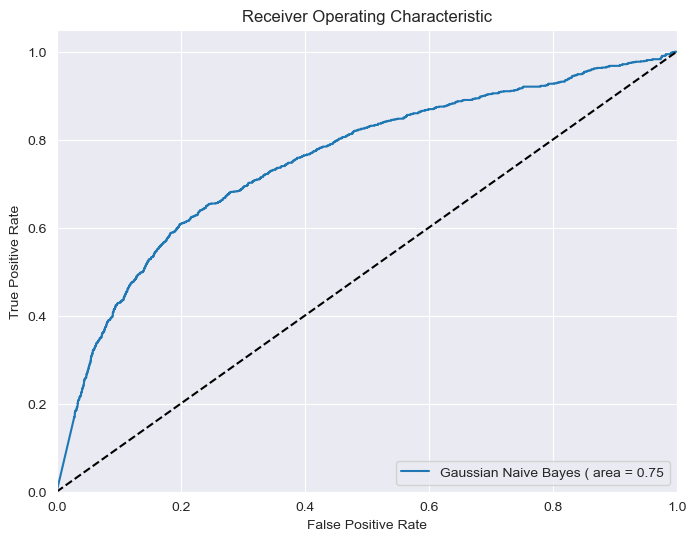

In [38]:
#Gaussian Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
y_pred_proba=gnb.predict_proba(X_test)[:,1]
print("Gaussian Naive Bayes")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gaussian Naive Bayes ( area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

KNeighbors with Scikit-learn training steps

K Neighbors Classifier
Accuracy:  0.8357845847616941
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.39      0.71      0.50      1058

    accuracy                           0.84      9043
   macro avg       0.67      0.78      0.70      9043
weighted avg       0.89      0.84      0.85      9043

Confusion Matrix: 
 [[6810 1175]
 [ 310  748]]
ROC AUC Score:  0.841241256940885


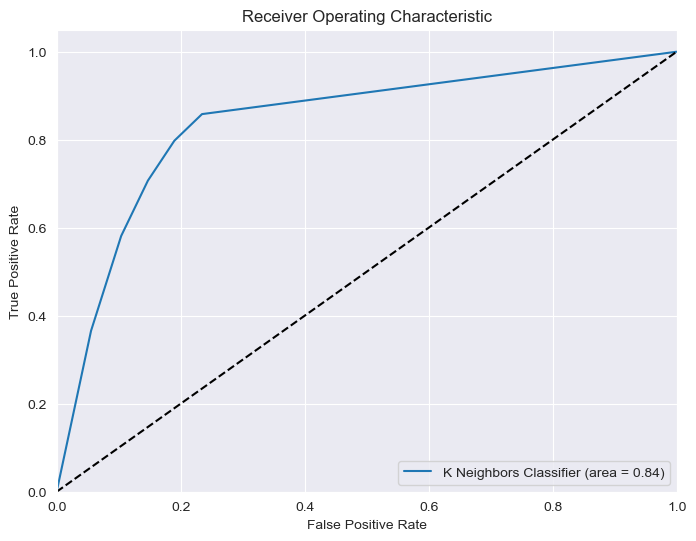

In [39]:
#K Neighbors Classifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
y_pred_proba=knn.predict_proba(X_test)[:,1]
print("K Neighbors Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='K Neighbors Classifier (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [40]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test)), 
                 accuracy_score(y_test, dtree.predict(X_test)), 
                 accuracy_score(y_test, rforest.predict(X_test)), 
                 accuracy_score(y_test, gbm.predict(X_test)), 
                 accuracy_score(y_test, svc.predict(X_test)), 
                 accuracy_score(y_test, gnb.predict(X_test)), 
                 accuracy_score(y_test, knn.predict(X_test))],
    'ROC_AUC_Score': [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, rforest.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])]
})

In [41]:
# Sort the results by ROC_AUC_Score in descending order
results = results.sort_values(by='ROC_AUC_Score', ascending = False,ignore_index = True)
# Display the results
print(results)

                  Model  Accuracy  ROC_AUC_Score
0         Random Forest  0.893619       0.919188
1                   SVC  0.856353       0.918281
2     Gradient Boosting  0.870950       0.908059
3   Logistic Regression  0.825611       0.890207
4           K Neighbors  0.835785       0.841241
5  Gaussian Naive Bayes  0.739135       0.753533
6         Decision Tree  0.869070       0.720875


In [42]:
# Save the model
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(dtree, 'dtree_model.pkl')
joblib.dump(rforest, 'rforest_model.pkl')
joblib.dump(gbm, 'gbm_model.pkl')
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(gnb, 'gnb_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(pre_pipeline, 'pre_pipeline.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [43]:
# Load the model
logreg_ = joblib.load('logreg_model.pkl')
dtree_ = joblib.load('dtree_model.pkl')
rforest_ = joblib.load('rforest_model.pkl')
gbm_ = joblib.load('gbm_model.pkl')
svc_ = joblib.load('svc_model.pkl')
gnb_ = joblib.load('gnb_model.pkl')
knn_ = joblib.load('knn_model.pkl')

In [44]:
# Make predictions on new data
new_data = pd.DataFrame({
    'age': [30],
    'balance': [1000],
    'day': [15],
    'duration': [200],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'job': ['admin.'],
    'contact': ['cellular'],
    'marital_status': ['single'],
    'education': ['university.degree'],
    'month': ['may'],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'credit_default': ['no']
})

In [45]:
# Preprocess the new data
new_data = pd.DataFrame(pre_processor.transform(new_data), columns=pre_processor.get_feature_names_out())
# Make predictions
logreg_pred = logreg_.predict(new_data)
dtree_pred = dtree_.predict(new_data)
rforest_pred = rforest_.predict(new_data)
gbm_pred = gbm_.predict(new_data)
svc_pred = svc_.predict(new_data)
gnb_pred = gnb_.predict(new_data)
knn_pred = knn_.predict(new_data)
# Print the predictions
print("Logistic Regression Prediction: ", logreg_pred)
print("Decision Tree Prediction: ", dtree_pred)
print("Random Forest Prediction: ", rforest_pred)
print("Gradient Boosting Prediction: ", gbm_pred)
print("SVC Prediction: ", svc_pred)
print("Gaussian Naive Bayes Prediction: ", gnb_pred)
print("K Neighbors Prediction: ", knn_pred)

Logistic Regression Prediction:  [1]
Decision Tree Prediction:  [1]
Random Forest Prediction:  [0]
Gradient Boosting Prediction:  [0]
SVC Prediction:  [0]
Gaussian Naive Bayes Prediction:  [1]
K Neighbors Prediction:  [1]


/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without 